# TSFRESH Robot Failure Example
This example show shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import FeatureExtractionSettings
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

## Load and visualize data
The data consists of timeseries for 88 robots (`id` 1 - 88).  For each robot, each timepoint (`time`) contains datapoints from 6 sensors (`a` - `f`) leading up to a success or failure (`y`).

In [3]:
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()

,id,time,a,b,c,d,e,f
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


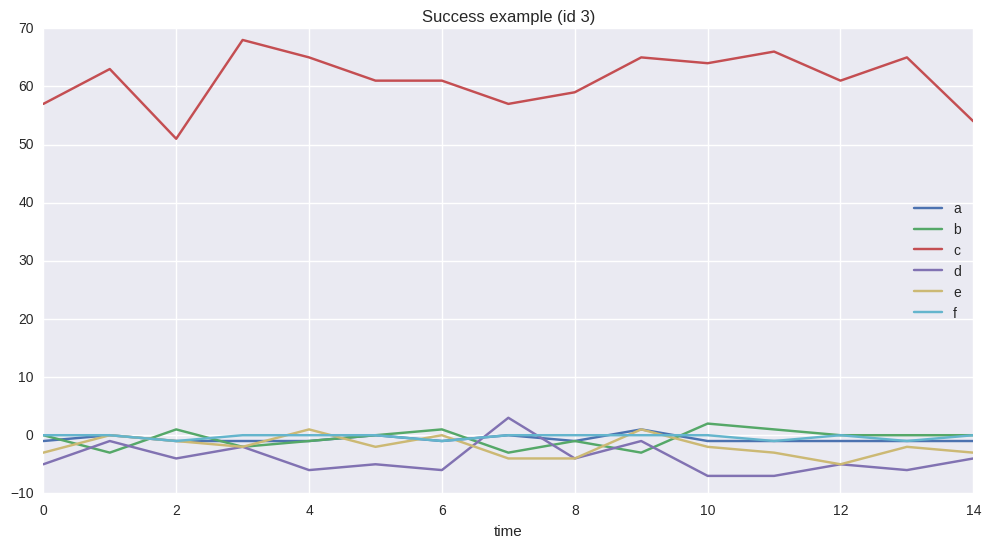

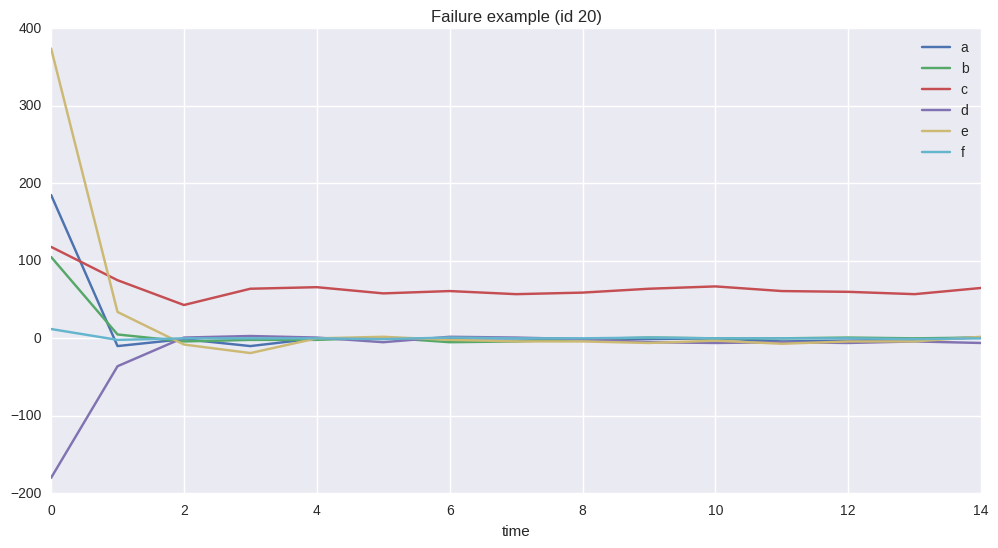

In [4]:
df[df.id == 3][['time', 'a', 'b', 'c', 'd', 'e', 'f']].plot(x='time', title='Success example (id 3)', figsize=(12, 6));
df[df.id == 20][['time', 'a', 'b', 'c', 'd', 'e', 'f']].plot(x='time', title='Failure example (id 20)', figsize=(12, 6));

## Extract Features

In [5]:
extraction_settings = FeatureExtractionSettings()
extraction_settings.IMPUTE = impute    # Fill in Infs and NaNs

In [6]:
%time X = extract_features(df, column_id='id', column_sort='time', feature_extraction_settings=extraction_settings);

/home/antonio/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/home/antonio/anaconda3/lib/python3.5/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 15, using nperseg = 15
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))
/home/antonio/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/home/antonio/anaconda3/lib/python3.5/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 15, using nperseg = 15
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))
/home/antonio/anaconda3/lib/python3.5/site-packages/pandas/computation/e

CPU times: user 45.9 s, sys: 84 ms, total: 46 s
Wall time: 46.2 s


In [7]:
X.head()

,b__sum_values,b__mean_autocorrelation,b__mean_abs_change_quantiles__qh_0.6__ql_0.0,b__symmetry_looking__r_0.9500000000000001,b__number_peaks__n_5,b__mean_abs_change_quantiles__qh_1.0__ql_0.8,b__large_standard_deviation__r_0.45,b__mean_abs_change_quantiles__qh_0.6__ql_0.4,b__number_cwt_peaks__n_5,b__mean_abs_change_quantiles__qh_1.0__ql_0.4,...,f__fft_coefficient__coeff_8,f__fft_coefficient__coeff_9,f__ar_coefficient__k_10__coeff_0,f__ar_coefficient__k_10__coeff_1,f__ar_coefficient__k_10__coeff_2,f__ar_coefficient__k_10__coeff_3,f__ar_coefficient__k_10__coeff_4,f__spkt_welch_density__coeff_2,f__spkt_welch_density__coeff_5,f__spkt_welch_density__coeff_8
1,-13.0,-0.182828,0.000000,1.0,0.0,0.214286,0.0,0.000000,1.0,0.214286,...,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
2,-10.0,-0.276052,1.285714,1.0,0.0,0.000000,0.0,0.000000,3.0,1.666667,...,0.0,0.0,-0.357143,-3.770318e-17,8.302785e-17,0.285714,0.107143,1.404534,0.023212,0.0
3,-8.0,-0.297708,1.285714,1.0,0.0,1.000000,0.0,0.000000,2.0,0.600000,...,0.0,0.0,-0.351351,-1.351351e-01,3.243243e-01,-0.027027,-0.162162,0.177580,0.231630,0.0
4,2.0,-0.017667,2.181818,1.0,1.0,1.333333,0.0,0.666667,2.0,1.200000,...,0.0,0.0,-0.313305,1.330472e-01,1.287554e-01,-0.270386,-0.004292,3.022578,0.375456,0.0
5,-4.0,-0.404353,1.000000,1.0,0.0,0.000000,0.0,0.666667,3.0,1.333333,...,0.0,0.0,-0.302158,1.654676e-01,5.035971e-02,0.129496,-0.093525,2.523583,0.371239,0.0


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 1236 entries, b__sum_values to f__spkt_welch_density__coeff_8
dtypes: float64(1236)
memory usage: 850.4 KB


In [9]:
%time X_filtered = extract_relevant_features(df, y, column_id='id', column_sort='time', feature_extraction_settings=extraction_settings)

/home/antonio/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/home/antonio/anaconda3/lib/python3.5/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 15, using nperseg = 15
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))
/home/antonio/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/home/antonio/anaconda3/lib/python3.5/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 15, using nperseg = 15
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))
/home/antonio/anaconda3/lib/python3.5/site-packages/pandas/computation/e

CPU times: user 52.3 s, sys: 104 ms, total: 52.4 s
Wall time: 52.3 s


In [10]:
X_filtered.head()

,a__abs_energy,a__range_count__max_1__min_-1,b__abs_energy,e__variance,e__standard_deviation,e__abs_energy,c__standard_deviation,c__variance,a__standard_deviation,a__variance,...,d__number_peaks__n_1,e__number_cwt_peaks__n_1,c__mean_abs_change_quantiles__qh_1.0__ql_0.8,d__quantile__q_0.1,b__has_duplicate_max,"b__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2","b__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5",e__quantile__q_0.1,a__quantile__q_0.2,b__quantile__q_0.7
1,14.0,15.0,13.0,0.222222,0.471405,10.0,1.203698,1.448889,0.249444,0.062222,...,1.0,4.0,0.0,-3.0,1.0,-0.310265,-0.751682,-1.0,-1.0,-1.0
2,25.0,13.0,76.0,4.222222,2.054805,90.0,4.333846,18.782222,0.956847,0.915556,...,4.0,4.0,1.0,-9.2,1.0,-0.202951,0.057818,-3.6,-1.0,-1.0
3,12.0,14.0,40.0,3.128889,1.768867,103.0,4.616877,21.315556,0.596285,0.355556,...,6.0,3.0,3.0,-6.6,0.0,0.539121,0.912474,-4.0,-1.0,0.0
4,16.0,10.0,60.0,7.128889,2.669998,124.0,3.833188,14.693333,0.952190,0.906667,...,5.0,5.0,0.0,-9.0,0.0,-2.641390,-0.609735,-4.6,-1.0,1.0
5,17.0,13.0,46.0,4.160000,2.039608,180.0,4.841487,23.440000,0.879394,0.773333,...,5.0,5.0,0.0,-9.6,0.0,0.591927,0.072771,-5.0,-1.0,0.8


In [11]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 307 entries, a__abs_energy to b__quantile__q_0.7
dtypes: float64(307)
memory usage: 211.8 KB


## Train and evaluate classifier

In [12]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)

In [13]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95         9
          1       1.00      0.96      0.98        27

avg / total       0.98      0.97      0.97        36



In [14]:
cl.n_features_

1236

In [15]:
cl2 = DecisionTreeClassifier()
cl2.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl2.predict(X_filtered_test)))

             precision    recall  f1-score   support

          0       0.82      1.00      0.90         9
          1       1.00      0.93      0.96        27

avg / total       0.95      0.94      0.95        36



In [16]:
cl2.n_features_

307

Compared to using all (1236) features, using only the (283) relevant features achieves better classification performance with less data.

# Extraction + filtering is the same as filtered extraction

Above, we performed two feature extractions runs. A filtered one and a non filtered one. However, the results of the filtered is equal to just extracting all features and then filtering them.

In [17]:
X_filtered_2 = select_features(X, y)

[test_feature_significance] Feature c__symmetry_looking__r_0.6000000000000001 is constant
[test_feature_significance] Feature b__large_standard_deviation__r_0.45 is constant
[test_feature_significance] Feature c__symmetry_looking__r_0.8 is constant
[test_feature_significance] Feature b__mean_abs_change_quantiles__qh_0.6__ql_0.8 is constant
[test_feature_significance] Feature a__value_count__value_inf is constant
[test_feature_significance] Feature c__symmetry_looking__r_0.4 is constant
[test_feature_significance] Feature c__large_standard_deviation__r_0.1 is constant
[test_feature_significance] Feature f__mean_abs_change_quantiles__qh_0.2__ql_0.2 is constant
[test_feature_significance] Feature e__value_count__value_-inf is constant
[test_feature_significance] Feature d__value_count__value_-inf is constant
[test_feature_significance] Feature f__mean_abs_change_quantiles__qh_0.6__ql_0.6 is constant
[test_feature_significance] Feature f__value_count__value_-inf is constant
[test_feature_s

In [18]:
(X_filtered.columns == X_filtered_2.columns).all()

True